In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kiwipiepy

# 데이터 합치기

In [ ]:
import os
import pandas as pd

def process_text_file(content):
    """텍스트 파일 내용을 전처리"""
    # 공백 제거 및 필요 없는 줄 필터링
    sentences = []
    groups = content.split('\n\n')
    for group in groups:
        lines = group.split("\n")
        for i in range(len(lines)):
            if i == 0:
                pass
            elif i == 1:
                pass
            else:
                sentences.append(lines[i].strip())
    return sentences

def process_all_text_files(folder_path):
    """특정 경로의 모든 .txt 파일을 처리하고 DataFrame 생성"""
    data = []

    # 경로 순회
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)

                # 파일 읽기
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()

                # 텍스트 전처리
                processed_text = process_text_file(content)

                # 파일 이름과 전처리된 텍스트 저장
                for line in processed_text:
                    data.append({'file_name': file[:-4], 'content': line})

    # DataFrame 생성
    df = pd.DataFrame(data)
    return df

In [ ]:
# 텍스트 파일이 있는 폴더 경로
folder_path = "/content/drive/MyDrive/subtitle"  # 폴더 경로를 입력하세요

# 함수 호출 및 DataFrame 생성
df = process_all_text_files(folder_path)

In [ ]:
df.tail(10)

file_name         content
49563  good_bad_strange   박 서방의 놀라는 소리]
49564  good_bad_strange          (박 서방)
49565  good_bad_strange            아아아!
49566  good_bad_strange            [철컥]
49567  good_bad_strange     - 다시 한번 묻는다
49568  good_bad_strange  - (박 서방) 아아...
49569  good_bad_strange      윤태구 어디 있냐?
49570  good_bad_strange       [철컥, 땡그랑]
49571  good_bad_strange           [부르릉]
49572  good_bad_strange        [경쾌한 음악]

# 데이터 전처리

In [ ]:
import pandas as pd
import re

# 문장 부호 제거
df['cleaned_content'] = df['content'].apply(lambda x: re.sub(r"[^\w\s]", "", x))

In [ ]:
df.head(10)

file_name              content    cleaned_content
0  taxi_driver             [흥겨운 음악]             흥겨운 음악
1  taxi_driver      [흥겨운 음악이 흘러나온다]      흥겨운 음악이 흘러나온다
2  taxi_driver                 (만섭)                 만섭
3  taxi_driver      ♪ 그 언젠가 나를 위해 ♪       그 언젠가 나를 위해 
4  taxi_driver  ♪ 꽃다발을 전해 주던 그 소녀 ♪   꽃다발을 전해 주던 그 소녀 
5  taxi_driver         ♪ 오늘따라 왜 이렇게         오늘따라 왜 이렇게
6  taxi_driver       그 소녀가 보고 싶을까 ♪      그 소녀가 보고 싶을까 
7  taxi_driver         ♪ 비에 젖은 풀잎처럼         비에 젖은 풀잎처럼
8  taxi_driver    단발머리 곱게 빗은 그 소녀 ♪   단발머리 곱게 빗은 그 소녀 
9  taxi_driver          ♪ 반짝이는 눈망울이          반짝이는 눈망울이

In [ ]:
from kiwipiepy import Kiwi
import pandas as pd

# Kiwi 형태소 분석기 초기화
kiwi = Kiwi()

# 컬럼 추가 함수
def extract_features(row):
    cleaned_content = row['cleaned_content']
    content = row['content']
    tokens = kiwi.analyze(cleaned_content)[0][0]

    # 형태소 분류
    proper_nouns = [token.form for token in tokens if token.tag in ['NNP']]  # 고유명사
    nouns = [token.form for token in tokens if token.tag in ['NNG', 'NNP', 'NNB', 'NR', 'NP']]  # 명사
    adjectives_adverbs = [token.form for token in tokens if token.tag in ['MM', 'MAG', 'XR', 'IC']]  # 관형사, 부사, 감탄사, 어
    verbs = [token.form for token in tokens if token.tag in ['VV', 'VA', 'VX', 'VCP', 'VCN']]  # 용언
    juct = [token.form for token in tokens if token.tag in ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC']]  # 조사
    end = [token.form for token in tokens if token.tag in ['EP', 'EF', 'EC', 'ETN', 'ETM']]  # 어미
    others = [token.form for token in tokens if token.tag not in ['NNG', 'NNP', 'NNB', 'NR', 'NP', 'MM', 'MAG', 'XR', 'IC', 'VV', 'VA', 'VX', 'VCP', 'VCN', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']]  # 기타

    # 연출적 표현 체크
    has_brackets = 1 if '[' in content and ']' in content else 0

    return {
        'length': len(cleaned_content.split()),
        'proper_nouns': proper_nouns,
        'nouns': nouns,
        'adjectives_adverbs': adjectives_adverbs,
        'verbs': verbs,
        'junt' : juct,
        'end' : end,
        'others': others,
        'directional_expression': has_brackets
    }

# Apply 함수로 컬럼 추가
features = df.apply(extract_features, axis=1)

# 컬럼 병합
for key in features.iloc[0].keys():
    df[key] = features.apply(lambda x: x[key])

# 결과 확인
df.head(5)

file_name              content    cleaned_content  length proper_nouns  \
0  taxi_driver             [흥겨운 음악]             흥겨운 음악       2           []   
1  taxi_driver      [흥겨운 음악이 흘러나온다]      흥겨운 음악이 흘러나온다       3           []   
2  taxi_driver                 (만섭)                 만섭       1           []   
3  taxi_driver      ♪ 그 언젠가 나를 위해 ♪       그 언젠가 나를 위해        4           []   
4  taxi_driver  ♪ 꽃다발을 전해 주던 그 소녀 ♪   꽃다발을 전해 주던 그 소녀        5           []   

       nouns adjectives_adverbs    verbs junt      end others  \
0       [음악]                 []       []   []      [은]   [흥겹]   
1       [음악]                 []   [흘러나오]  [이]  [은, ᆫ다]   [흥겹]   
2       [만섭]                 []       []   []       []     []   
3    [언제, 나]                [그]  [이, 위하]  [를]  [ᆫ가, 어]     []   
4  [꽃다발, 소녀]                [그]  [전하, 주]  [을]   [어, 던]     []   

   directional_expression  
0                       1  
1                       1  
2                       0  
3                       0  
4                       0

In [ ]:
# DataFrame 저장
df.to_csv('/content/drive/MyDrive/subtitles.csv', index=False, encoding='utf-8')

print("모든 파일이 처리되었으며, 결과가 'subtitles.csv'에 저장되었습니다.")

모든 파일이 처리되었으며, 결과가 'subtitles.csv'에 저장되었습니다.


# 고유 명사 워드클라우드

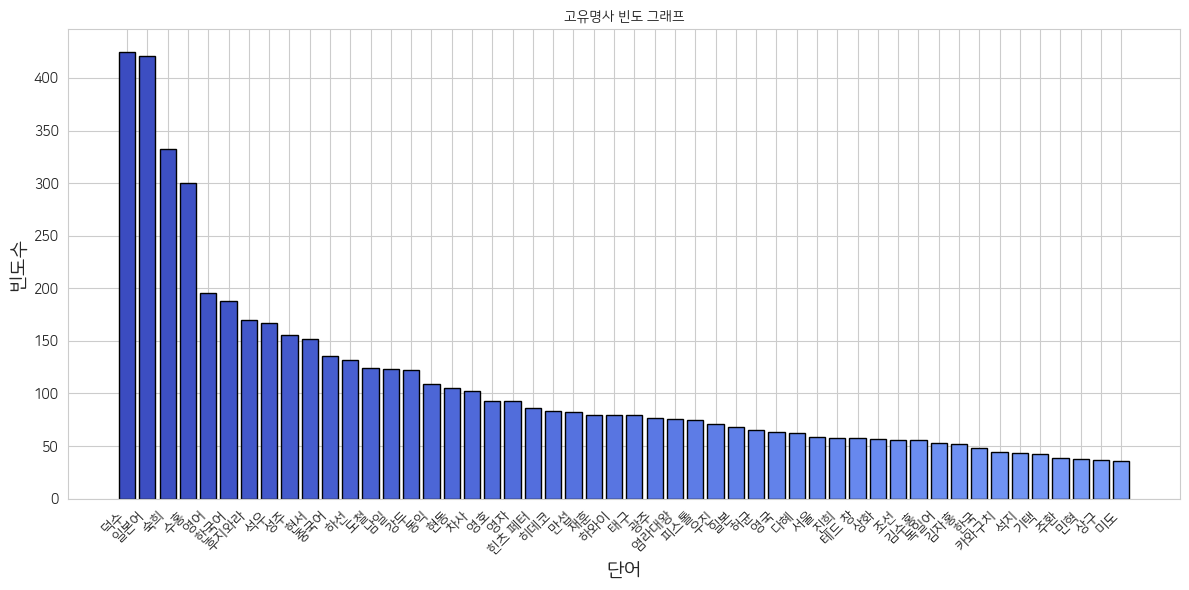

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.font_manager as fm

# 나눔 고딕 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 불용어 제거 후 명사 리스트 정리
filtered_nouns = [word for word in all_nouns if len(word) > 1 and word not in stop_words]

# 단어 빈도 계산
word_counts = Counter(filtered_nouns)
top_words = word_counts.most_common(50)  # 상위 10개 단어
words, counts = zip(*top_words)

# 막대그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color=plt.cm.coolwarm(range(len(words))), edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title("고유명사 빈도 그래프", fontsize=18, fontweight='bold', fontproperties=font_prop)
plt.xlabel("단어", fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.ylabel("빈도수", fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.xticks(fontsize=12, fontproperties=font_prop, rotation=45, ha='right')  # 단어 기울임
plt.yticks(fontsize=12, fontproperties=font_prop)

# 여백 최적화 및 출력
plt.tight_layout()
plt.show()

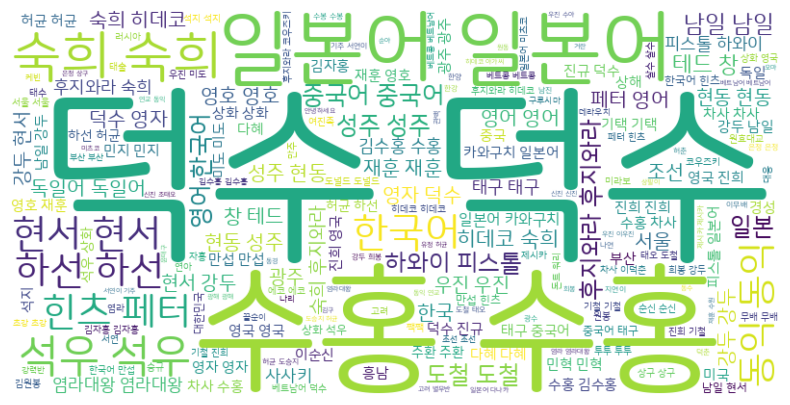

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['proper_nouns'].sum()

# 불용어 리스트 정의
stop_words = {'로'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word)>1 and word not in stop_words ]
filtered_nouns_text = ' '.join(filtered_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_nouns_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

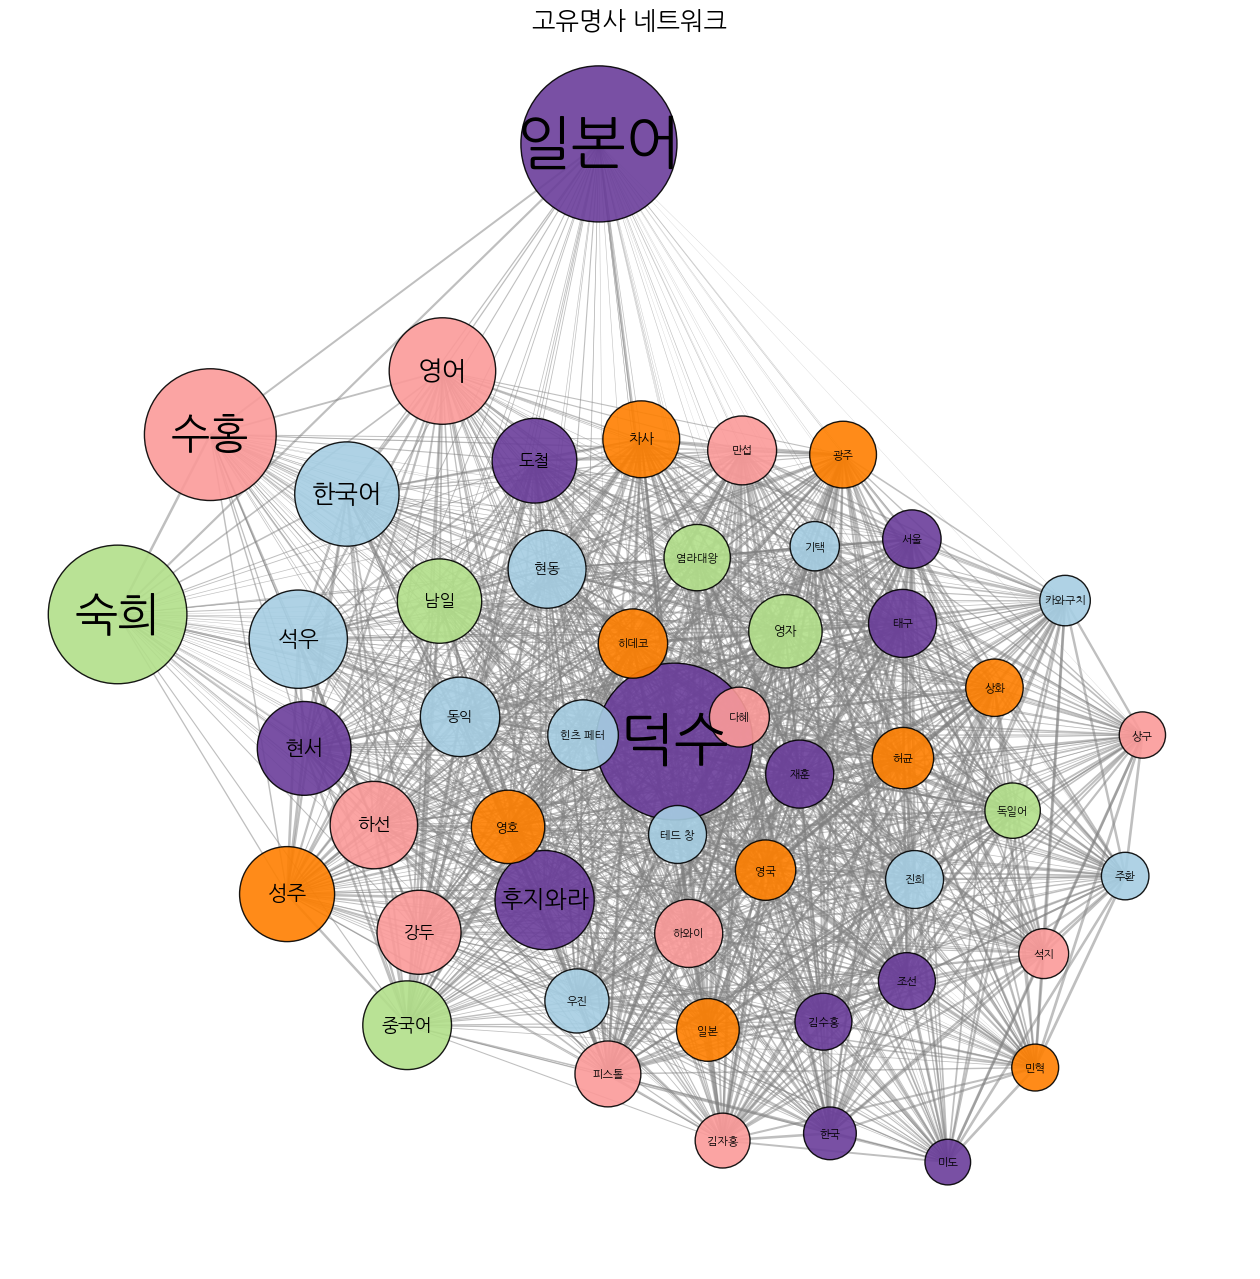

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.colors import to_rgba
import random

# 명사 데이터를 Counter를 사용해 빈도 계산
word_counts = Counter(filtered_nouns)

# 상위 50개 단어만 유지
filtered_nodes = word_counts.most_common(50)

# 그래프 생성
G = nx.Graph()

# 노드 추가
for word, freq in filtered_nodes:
    G.add_node(word, size=freq, group=random.randint(0, 4))  # 그룹을 무작위로 지정

# 간선 추가 (단순히 빈도 기반 연결)
for i, (word1, freq1) in enumerate(filtered_nodes):
    for j, (word2, freq2) in enumerate(filtered_nodes):
        if i < j:  # 중복 간선 방지
            weight = min(freq1, freq2) / max(freq1, freq2)
            G.add_edge(word1, word2, weight=weight)

# 노드 중심성 계산 (Degree 중심성 사용)
centrality = nx.degree_centrality(G)

# 중심 노드 선택 (중심성이 가장 높은 노드)
most_central_node = max(centrality, key=centrality.get)

# 레이아웃 설정: 중심 노드 중심으로 배치
pos = nx.spring_layout(G, seed=42, k=1.0)
pos[most_central_node] = [0, 0]  # 중심 노드를 정확히 가운데 배치

# 노드 크기 및 그룹별 색상 설정
groups = nx.get_node_attributes(G, 'group')
unique_groups = list(set(groups.values()))
color_map = {group: plt.cm.Paired(i / len(unique_groups)) for i, group in enumerate(unique_groups)}
node_colors = [color_map[groups[node]] for node in G.nodes()]
sizes = [G.nodes[node]['size'] * 30 for node in G.nodes()]  # 크기 조정

# 글씨 크기 설정: 노드 크기에 비례
font_sizes = {node: max(int(size / 300), 8) for node, size in zip(G.nodes(), sizes)}  # 최소 크기 8로 제한

# 엣지 가중치에 따른 두께 및 투명도 설정
edges = G.edges(data=True)
edge_widths = [edge['weight'] * 2 for _, _, edge in edges]
edge_colors = [to_rgba('gray', alpha=edge['weight']) for _, _, edge in edges]

# 네트워크 그래프 그리기
plt.figure(figsize=(16, 16))  # 그래프 캔버스 확대
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.9, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)

# 노드에 비례한 글씨 크기 적용
for node, (x, y) in pos.items():
    plt.text(
        x, y, node,
        fontsize=font_sizes[node],
        fontfamily='NanumGothic',
        horizontalalignment='center',
        verticalalignment='center'
    )

# 제목 추가
plt.title("고유명사 네트워크", fontsize=18)
plt.axis('off')
plt.show()

# 명사 워드클라우드

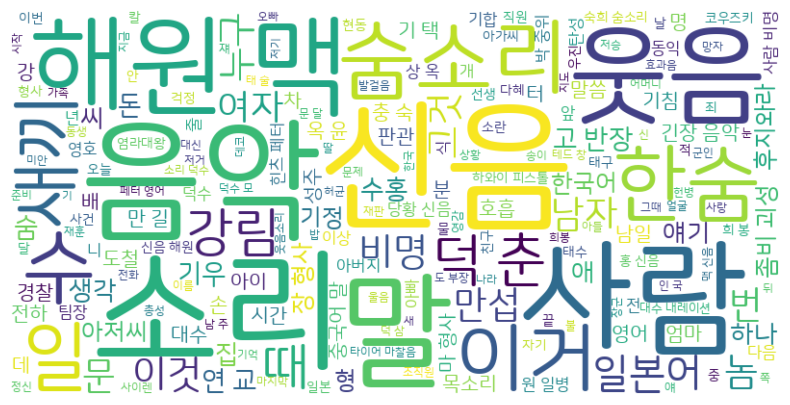

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['nouns'].sum()

# 불용어 리스트 정의
stop_words = {'이', '그', '저', '거기', '뭐', '왜', '그거', '너희', '저희', '우리', '당신', '것', '때문', '나', '너', '내', '제', '그냥', '아니', '거', '나', '것', '여기', '어디'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if word not in stop_words]
filtered_nouns_text = ' '.join(filtered_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_nouns_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

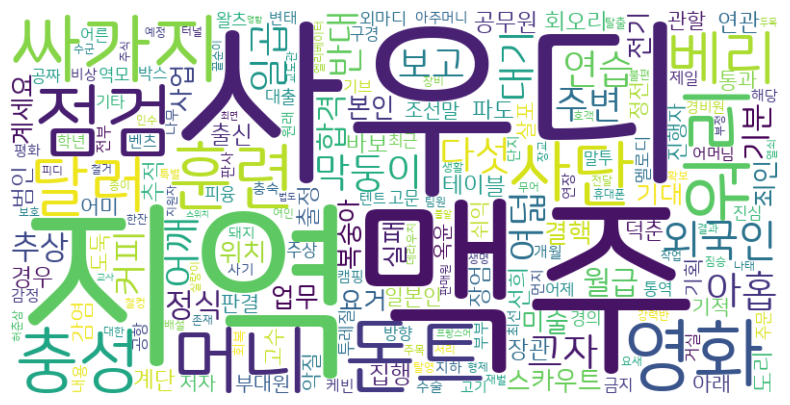

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['nouns'].sum()

# 불용어 리스트 정의
stop_words = {'이', '그', '저', '거기', '뭐', '왜', '그거', '너희', '저희', '우리', '당신', '것', '때문', '나', '너', '내', '제', '그냥', '아니', '거', '나', '것', '여기', '어디'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word)>1 and word not in stop_words]

# 빈도 계산
word_counts = Counter(filtered_nouns)

# 빈도수가 너무 높은 단어 필터링 (예: 상위 5개 제외)
max_frequency_threshold = 10  # 빈도수가 50 이상인 단어를 제외
filtered_word_counts = {word: count for word, count in word_counts.items() if count < max_frequency_threshold}

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(filtered_word_counts)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 관형사 워드클라우드

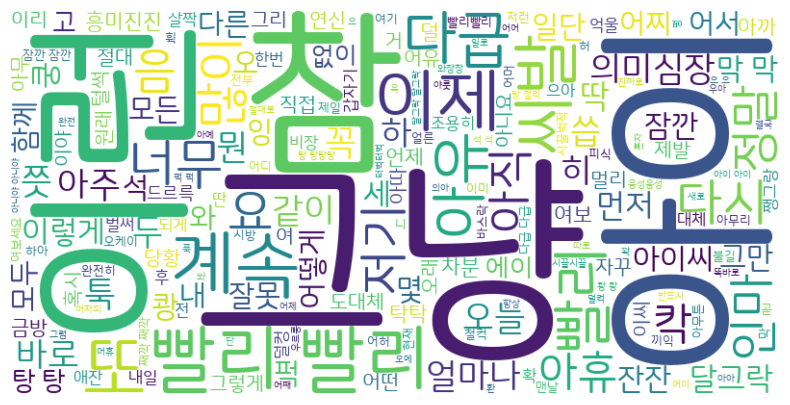

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['adjectives_adverbs'].sum()

# 불용어 리스트 정의
stop_words = {'어', '안', '좀', 'ㅎ', '아', '이', '다', '지금', '아니', '뭐', '야', '예', '다', '왜', '잘', '한', '저', '그', '씨', '응', '못', '진짜', '아이고', '네', '자', '무슨', '더', '그래', '그런', '탁'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if word not in stop_words]
filtered_nouns_text = ' '.join(filtered_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_nouns_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 용언 워드클라우드

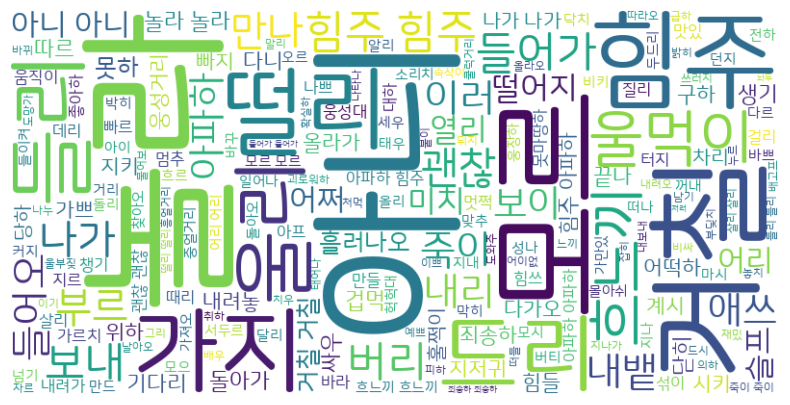

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['verbs'].sum()

# 불용어 리스트 정의
stop_words = {'그러', '나오'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word)>1 and word not in stop_words ]
filtered_nouns_text = ' '.join(filtered_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_nouns_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 조사 워드클라우드

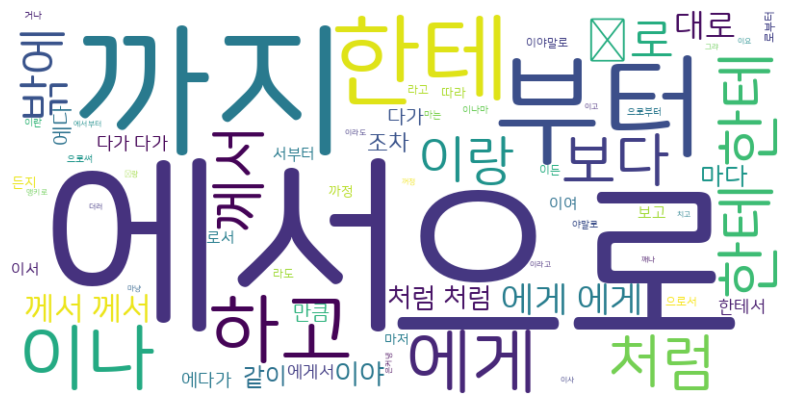

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['junt'].sum()

# 불용어 리스트 정의
stop_words = {'로'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word)>1 and word not in stop_words ]
filtered_nouns_text = ' '.join(filtered_nouns)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_nouns_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 한글 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 설치된 폰트 확인
!fc-list :lang=ko

# matplotlib에 한글 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 등록
fm.fontManager.addfont(font_path)

# 폰트 설정
plt.rc('font', family='NanumGothic')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123652 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

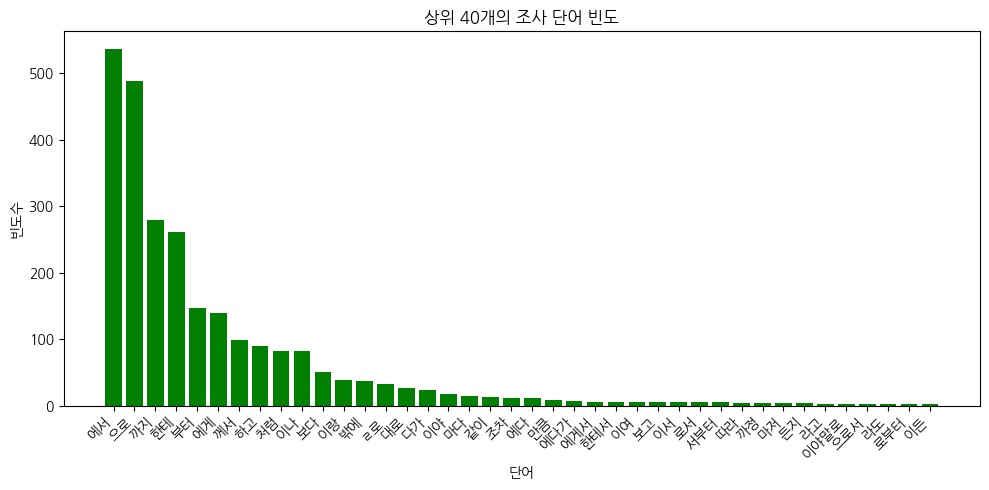

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['junt'].sum()

# 불용어 리스트 정의
stop_words = {'로'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word)>1 and word not in stop_words ]

# 단어 빈도 계산
word_counts = Counter(filtered_nouns)

# 상위 20개 단어 선택
top_words = word_counts.most_common(40)

# 데이터 분리
words, counts = zip(*top_words)

# 막대그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='green')
plt.xlabel('단어')
plt.ylabel('빈도수')
plt.title('상위 40개의 조사 단어 빈도')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-71-36f4ef42eba9>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {group: plt.cm.get_cmap('tab10')(i / len(unique_groups)) for i, group in enumerate(unique_groups)}


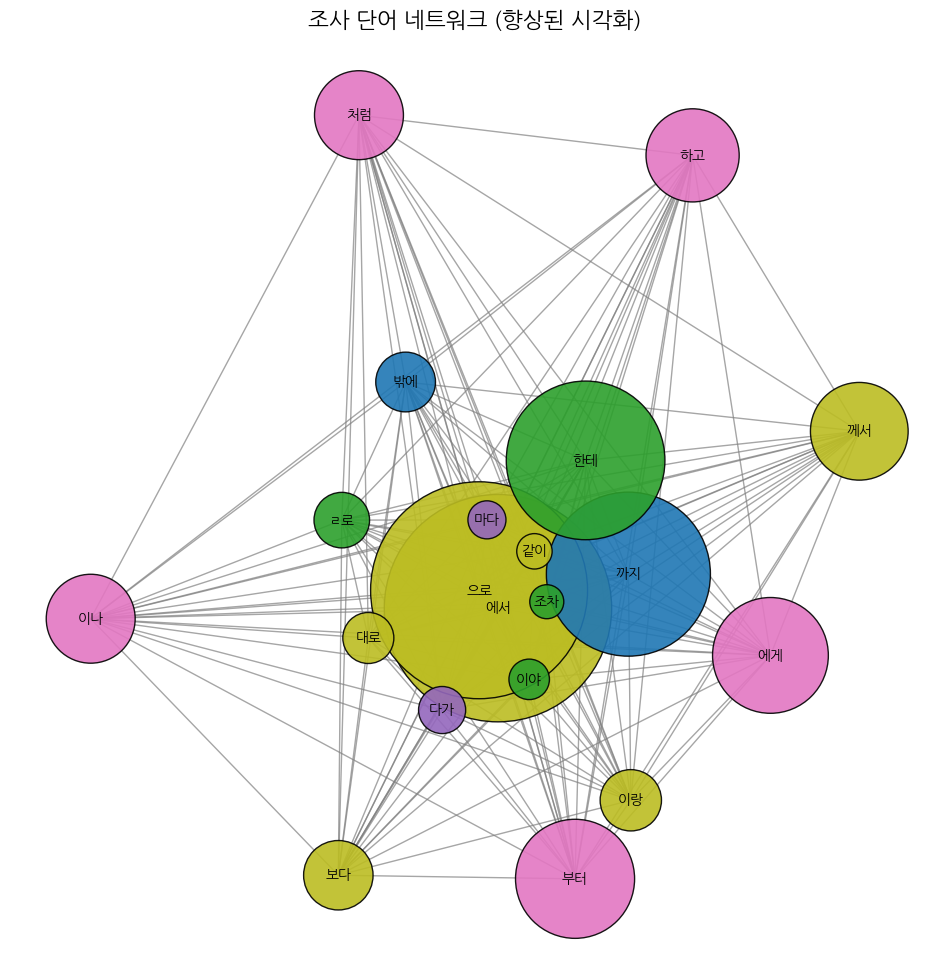

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import random

# 상위 20개 단어만 유지하되, 특정 크기 이상의 노드는 제외
max_node_size = 10000  # 이 값을 조정하여 너무 큰 노드를 제거
filtered_nodes = [(word, freq) for word, freq in word_counts.most_common(20) if freq <= max_node_size]

# 그래프 생성
G = nx.Graph()

# 노드 추가
for word, freq in filtered_nodes:
    G.add_node(word, size=freq, group=random.randint(0, 4))  # 0~4 그룹 무작위 할당

# 간선 추가 (간단히 빈도 기반 연결)
for i, (word1, freq1) in enumerate(filtered_nodes):
    for j, (word2, freq2) in enumerate(filtered_nodes):
        if i < j:  # 중복 간선 방지
            weight = min(freq1, freq2) / max(freq1, freq2)
            G.add_edge(word1, word2, weight=weight)

# 레이아웃 설정 (Kamada-Kawai Layout 사용)
pos = nx.kamada_kawai_layout(G)

# 노드 크기 및 그룹별 색상 설정
groups = nx.get_node_attributes(G, 'group')
unique_groups = list(set(groups.values()))
color_map = {group: plt.cm.get_cmap('tab10')(i / len(unique_groups)) for i, group in enumerate(unique_groups)}
node_colors = [color_map[groups[node]] for node in G.nodes()]
sizes = [G.nodes[node]['size'] * 50 for node in G.nodes()]  # 크기 조정

# 엣지 가중치에 따른 투명도 설정
edges = G.edges(data=True)
edge_colors = [to_rgba('gray', alpha=edge['weight']) for _, _, edge in edges]

# 네트워크 그래프 그리기
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.9, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_family='NanumGothic', font_size=10)

# 제목 추가
plt.title("조사 단어 네트워크", fontsize=16)
plt.axis('off')
plt.show()

# 어미 워드 클라우드

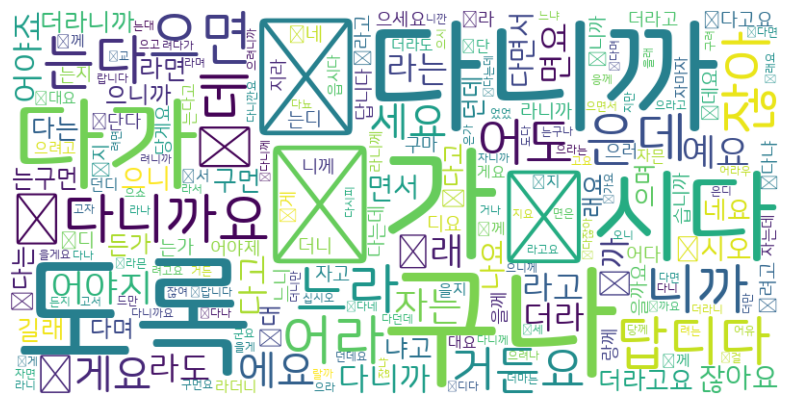

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Nanum Gothic 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'

# nouns 컬럼에서 명사 리스트 합치기
all_nouns = df['end'].sum()

# 불용어 리스트 정의
stop_words = {'을까', '려고', '는데', 'ㅛ', '어야', '어다가'}

# nouns에서 불용어 제거
filtered_nouns = [word for word in all_nouns if len(word) > 1 and word not in stop_words]

# 단어 빈도 계산
word_counts = Counter(filtered_nouns)

# 임계값 설정 (최대 빈도를 제한)
max_frequency = 500  # 이 값 이상인 단어는 제외
filtered_words = [word for word, count in word_counts.items() if count <= max_frequency]
filtered_text = ' '.join(filtered_words)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 설정
    width=800,
    height=400,
    background_color='white'
).generate(filtered_text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-137-1d307fdec461>:32: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from current font.
  plt.tight_layout()
<ipython-input-137-1d307fdec461>:32: UserWarning: Glyph 4536 (\N{HANGUL JONGSEONG PIEUP}) missing from current font.
  plt.tight_layout()
<ipython-input-137-1d307fdec461>:32: UserWarning: Glyph 4527 (\N{HANGUL JONGSEONG RIEUL}) missing from current font.
  plt.tight_layout()


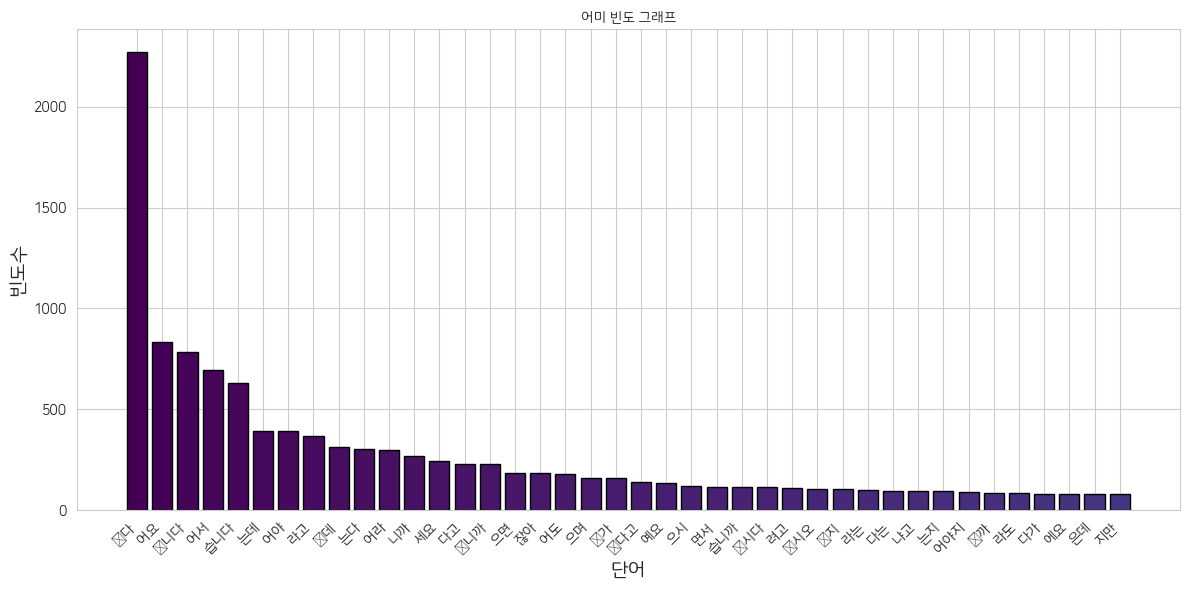

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.font_manager as fm

# 나눔 고딕 폰트 경로 설정
font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 불용어 제거 후 명사 리스트 정리
filtered_nouns = [word for word in all_nouns if len(word) > 1 and word not in stop_words]

# 단어 빈도 계산
word_counts = Counter(filtered_nouns)
top_words = word_counts.most_common(40)  # 상위 20개 단어
words, counts = zip(*top_words)

# 색상 설정
colors = plt.cm.viridis(range(len(words)))

# 막대그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color=colors, edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title("어미 빈도 그래프", fontsize=18, fontweight='bold', fontproperties=font_prop)
plt.xlabel("단어", fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.ylabel("빈도수", fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.xticks(fontsize=12, fontproperties=font_prop, rotation=45, ha='right')  # 단어 기울임
plt.yticks(fontsize=12, fontproperties=font_prop)

# 여백 최적화 및 출력
plt.tight_layout()
plt.show()